In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from sklearn.metrics import r2_score

### Define functions
#### Assign signals of protein ligand complex to closest signal in apo spectrum
***

In [2]:
def xml2shifts(infile, sequence_offset, outfile=""):
    """
    read peaklist.xml from topspin and process the file
    """

    df_peaks = pd.read_xml(infile, xpath=".//Peak2D")
    df_peaks.index = df_peaks.index + 1                                # index starts at 1

    df_peaks["F1"] = df_peaks["F1"].round(3)
    df_peaks["F2"] = df_peaks["F2"].round(3)
    df_peaks["N"] = "N"
    df_peaks["H"] = "H"
    df_peaks["dummyzero"] = "0.000"                                    # required column in prot files


    if len(outfile) > 0:
        # write N shifts
        df_peaks.to_csv(outfile, header=False, columns=["F1", "dummyzero", "N", "annotation"], sep=" ")

        # write H shifts
        df_peaks.to_csv(outfile, mode="a", header=False, columns=["F2", "dummyzero", "H", "annotation"], sep=" ")
    return df_peaks

def write_peaklistxml(df_name, filename = "peaklist.xml", columns_name = ["F2_shifted", "F1_shifted", "annotation", "intensity", "type"]):
    
    df_name_rename = df_name.rename(columns={columns_name[0] : "F2", columns_name[1]:"F1"})
    
    shifts_xlm = df_name_rename.to_xml(attr_cols = ["F1", "F2", "annotation", "intensity", "type"], index=False, row_name="Peak2D")
    
    with open(filename, 'w') as f:  # Writing in XML file
        f.write("<?xml version='1.0' encoding='utf-8'?>\n")
        f.write('<PeakList modified="2023-03-12T09:14:19">\n')
        f.write("<PeakList2D>\n")
        f.write('<PeakList2DHeader creator="xxx" date="1970-01-01T00:00:00" expNo="1" name="xxx" owner="xxx" procNo="1" source="xxx">\n')
        f.write("<PeakPickDetails>\n")
        f.write("</PeakPickDetails>\n")
        f.write("</PeakList2DHeader>\n")
        f.write("#")
    with open(filename, 'a') as f:  # Writing in XML file
        for line_nr, line in enumerate(shifts_xlm):
            f.write(line)
    with open(filename, 'a') as f:  # Writing in XML file
        f.write("\n</PeakList2D>\n")
        f.write("</PeakList>\n")
    with open(filename, "r") as f:
        lines = f.readlines()
    with open(filename, "w") as f:
        for line in lines:
            if line.strip("\n") != "<data>":
                if line.strip("\n") != "</data>":
                    if "#" not in line.strip("\n"):
                        f.write(line)

def NH_csp(H_1, N_1, H_2, N_2):
    """
    compute averaged chemical shift
    H_1, N_1, H_2, N_2 .. H and N shifts for spectrum 1 and 2
    """
    return np.sqrt((0.2 * (N_1 - N_2))**2 + (H_1 - H_2)**2)

def map_peaks(df_assigned, df_unassigned, distance_function=NH_csp):
    

    
    NH_distances = []
    
    for NH in list(zip(df_assigned["F2"], df_assigned["F1"])):
        _list = np.fromiter(map(
            lambda H, N : distance_function(NH[0], NH[1], H, N), 
             list(df_unassigned["F2"]), list(df_unassigned["F1"])
                                              ), dtype=np.dtype(float))
        NH_distances.append(_list)
    
    # select smallest distance in distance matrix
    #############################################
    
    NH_shifted = np.array(NH_distances)
    
    list_index_min_x = []
    list_index_min_y = []
    dict_index = {}
    
    nr_assigned = df_assigned.shape[0]
    nr_peaks_unassigned = df_unassigned.shape[0]
    
    df_assigned.reset_index(inplace=True)
    df_unassigned.reset_index(inplace=True)
    
    df_assigned.index = df_assigned.index 
    df_unassigned.index = df_unassigned.index 
    
    df_assigned["index_col"] = df_assigned.index   
    df_unassigned["index_col"] = df_unassigned.index
    
    df_assigned.sort_values(by="index_col")
    df_unassigned.sort_values(by="index_col")
    
    NH_shifted = np.array(NH_distances)
    NH_shifted_flat = NH_shifted.flatten()
    
    # print(NH_shifted)


    # while (len(list_index_min_x) < nr_assigned) & (len(list_index_min_x) < nr_peaks_unassigned):
    for i in range(nr_peaks_unassigned):
        min_pos = np.argmin(NH_shifted_flat)
        min_x = np.floor_divide((min_pos), nr_peaks_unassigned)
        min_y = (min_pos) % nr_peaks_unassigned

        # print("-----" )
        # print(min_pos)

        if (min_x in list_index_min_x):
            NH_shifted_flat[min_pos] = 1000
            continue

        if (min_y in list_index_min_y):
            NH_shifted_flat[min_pos] = 1000
            continue

        list_index_min_x.append(min_x)
        list_index_min_y.append(min_y)
        dict_index[min_x] = min_y
        NH_shifted_flat[min_pos] = 1000


    dict_index_sorted = dict(sorted(dict_index.items(), key=lambda item: item[1]))
    # print(dict_index_sorted)
    df_unassigned["index_col"] = list(dict_index_sorted.keys())
    
    # print(list(dict_index_sorted.keys()))
    # print("df_unassigned")
    # print(df_unassigned)
    # print("df_assigned")
    # print(df_assigned)
        
    df_mapped = df_assigned.merge(df_unassigned, on="index_col", how="right")
    
       
    df_mapped.rename(columns=
                      {"F1_x": "F1_apo", "F2_x":"F2_apo", "annotation_x":"annotation", 
                       "F1_y": "F1_shifted", "F2_y": "F2_shifted", "intensity_y" : "intensity",
                       "N_x":"N", "H_x":"H", "type_y":"type"}, inplace=True)
    
    # # Print assigned peaks before dropping duplicates
    # print("Assigned Peaks Before Dropping Redundant Ones:")
    # print(df_mapped)
    
    # Drop redundant peaks within the same iteration, based on the shifts
    df_mapped = df_mapped.drop_duplicates(subset=["F1_shifted", "F2_shifted"])
    
    df_mapped = df_mapped[["F1_apo", "F2_apo", "annotation", "N", "H", "type", "F1_shifted", "F2_shifted", "intensity"]]
    
    df_mapped.dropna(inplace=True)
    df_mapped["type"] = df_mapped["type"].astype(int)
    
    # print("Mapped Peaks:")
    # print(df_mapped)
    # print("-----")
    
    return df_mapped.sort_values(by="annotation"), NH_distances, df_assigned, df_unassigned


def readtab(infile):
    # read NMRDRAW tab file from ccpNMR export

    shifts = pd.read_csv(infile, sep="[ ]+", skiprows=7, header=None, engine='python')
    shifts.rename(columns = {5: "F2", 6 : "F1", 17 : "intensity", 22 : "assignment"}, inplace = True)
    shifts = shifts[["F2", "F1", "intensity", "assignment"]]
    shifts["annotation"] = [i.split(".")[0] for i in shifts["assignment"]]
    shifts["annotation"] = shifts["annotation"].astype(int)
    shifts["annotation"] = shifts["annotation"]
    shifts["type"] = "0"
    return shifts

### Assign signals of protein ligand complex to closest signal in apo spectrum
***

In [3]:
# Define path to the measurements
sequence_offset = 0
dataset = "/Users/lucas/Documents/UZH/4_jahr_HS_2023/ResearchProject_NMR/Data/Phos_230822_b2_03_GM15_HMQC/"

# Define which measurements and the last measurement, from which the fucntion starts
apo_peaklist = dataset + "632" + "/pdata/1/peaklist.xml"
ligand_list_unassigned = [632, 572, 512, 452, 392, 332, 272, 212, 152, 92, 32]

# Define measurement time interval
t_period = 4.9

for i, data in enumerate(ligand_list_unassigned[:-1]):
    apo_peaklist = dataset + str(data) + "/pdata/1/peaklist.xml"
    ligand_peaklist_unassigned = dataset + str(ligand_list_unassigned[i + 1]) + "/pdata/1/peaklist.xml"
    
    df_apo = xml2shifts(apo_peaklist, sequence_offset, outfile="")
    df_ligand_unassigned = xml2shifts(ligand_peaklist_unassigned, sequence_offset, outfile="")

    df_apo_shifted, NH_shifted, df_assigned, df_unassigned = map_peaks(df_apo, df_ligand_unassigned, distance_function=NH_csp)
    # print(ligand_peaklist_unassigned)
    write_peaklistxml(df_apo_shifted, filename = ligand_peaklist_unassigned, columns_name = ["F2_shifted", "F1_shifted", "annotation", "intensity", "type"])
    # print("XML file written:", ligand_peaklist_unassigned)
    

#### Collect peaklists.xml 

In [4]:
apo_peaklist = dataset + str(ligand_list_unassigned[0]) + "/pdata/1/peaklist.xml"
df_apo = xml2shifts(apo_peaklist, sequence_offset=0, outfile="")
df_apo.drop(["dummyzero", "type", "N", "H", "F1", "F2"], axis = 1, inplace=True)

for i, data in enumerate(ligand_list_unassigned[1:]):
    
    ligand_peaklist = dataset + str(data) + "/pdata/1/peaklist.xml"
    
    df_ligand = xml2shifts(ligand_peaklist, sequence_offset=0, outfile="")     
    df_ligand.drop(["dummyzero", "type", "N", "H", "F1", "F2"], axis = 1, inplace=True)
      
    df_apo = df_apo.merge(df_ligand, on="annotation", how="left")

    col_name = str(data)
    df_apo = df_apo.rename(columns = {"intensity" : col_name})

df_apo = df_apo.rename(columns = {"intensity_x" : ligand_list_unassigned[0] , "intensity_y": ligand_list_unassigned[1]})

### Intensity vs. Time Plot

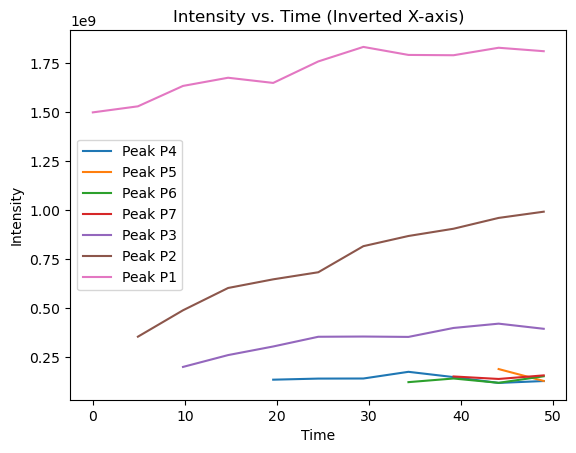

In [5]:
deltaT = np.array([i * t_period for i in range(df_apo.shape[1] - 1)]) 

# Generate peak list
peak_list = df_apo["annotation"].tolist()

# Iterate through peaks and plot with inverted x-values
for peak in peak_list:
    intensity = df_apo[df_apo["annotation"] == peak].values[0, 1:]
    
    # Invert the x-values
    inverted_deltaT = deltaT[::-1]
    
    plt.plot(inverted_deltaT, intensity, label=f'Peak {peak}')

# Add labels to x and y axes
plt.xlabel('Time')
plt.ylabel('Intensity')

plt.legend()  # Display legend

# Get the filename from the path
basename = os.path.basename(dataset)
# Remove the file extension
title = os.path.splitext(basename)[0]

# Add the filename as the plot title
plt.title("Intensity vs. Time (Inverted X-axis)")

plt.show()

### Generating an intensity_array out of df_apo, normalising it and reducing to the array which we want to fit

In [6]:
# Extract values starting from the first row (index 0) and the third column (index 2) onwards
intensities_array = df_apo.iloc[0:, 1:].values

# Convert any NaN values to 0 if needed
intensities_array = np.nan_to_num(intensities_array, nan=0)
print("\n original array:\n", intensities_array)

# Specify the reference row (from which to take values for normalization)
reference_row_index = 6  # For example, using row 2 as the reference row

# Initialize an empty array to store the normalized data
normalised_array = np.empty_like(intensities_array)

# Normalize each row with the corresponding element in the reference row, column by column
for column in range(intensities_array.shape[1]):
    reference_value = intensities_array[reference_row_index, column]
    normalised_array[:, column] = intensities_array[:, column] / reference_value

# Adding a small offset to value 0, enables use of log later on
# Define the small offset
offset = 1e-10
# Create a mask for zero values
zero_mask = normalised_array == 0.0
# Add the offset only to the zero values
normalised_array[zero_mask] += offset
print("\n normalised data, small offset added to zero: \n", normalised_array)

# Reducing the array to the rows of interest
to_be_fit_array = normalised_array[4:6, :] #row 0 and 1 are now fitted
# print("\n to be fitted data:\n", to_be_fit_array)

# Invert the columns
to_be_fit_array_inverted = to_be_fit_array[:, ::-1]
print("\nInverted array:", to_be_fit_array_inverted, "\n")


 original array:
 [[1.28343040e+08 1.18655488e+08 1.48405760e+08 1.75365120e+08
  1.41208576e+08 1.40758528e+08 1.35195392e+08 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.28632832e+08 1.89454848e+08 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.52645632e+08 1.19140864e+08 1.41225472e+08 1.22655744e+08
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.57158912e+08 1.38884096e+08 1.51629824e+08 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.95063808e+08 4.21294080e+08 3.99340544e+08 3.53614848e+08
  3.55510784e+08 3.54340864e+08 3.04741888e+08 2.60815360e+08
  2.00342528e+08 0.00000000e+00 0.00000000e+00]
 [9.93078272e+08 9.61263104e+08 9.06068480e+08 8.68970496e+08
  8.16978944e+08 6.83790848e+08 6.47638528e+08 6.03461120e+

### Plotting and Fitting the Data

Annotation P4 Fit Parameters: k=0.07131600031813373
Annotation P4 R-squared: 0.9355097683871052
Annotation P5 Fit Parameters: k=0.06897439345524636
Annotation P5 R-squared: 0.9634666447992687


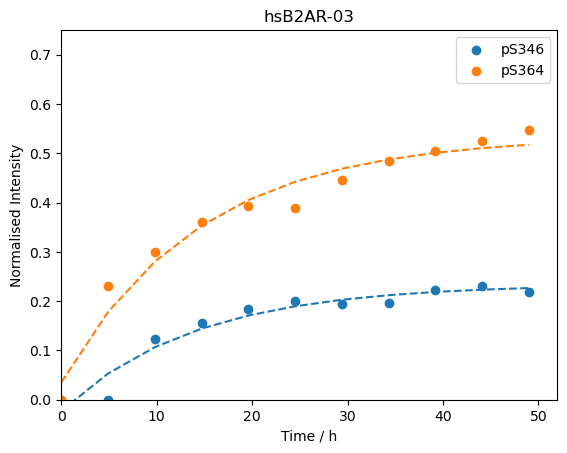

[ 0.   4.9  9.8 14.7 19.6 24.5 29.4 34.3 39.2 44.1 49. ]


In [7]:
# Define the modified exponential decay function
def exponential_decay(t, A_offset, A0, k):
    return A_offset + A0 * np.exp(-k * t)

# Create a figure and axis
fig, ax = plt.subplots()

# Initialize a list to store the R-squared values for each fit
r_squared_values = []

# Define the data labels
data_labels = ["pS346", "pS364"]

for i in range(to_be_fit_array_inverted.shape[0]):
    annotation = peak_list[i]
    intensities = to_be_fit_array_inverted[i, 0:]
    
    try:
        # Find the index where the intensities become nonzero
        first_nonzero_index = next((idx for idx, val in enumerate(intensities) if val != 0), None)
        
        if first_nonzero_index is not None:
            # Select a subset of the data from the first nonzero intensity onwards
            selected_intensities = intensities[first_nonzero_index:]
            selected_deltaT = deltaT[first_nonzero_index:]
            
            # Make sure we have enough data points for the fit
            if len(selected_intensities) >= 3:
                # Perform a linear fit on the logarithm of selected intensities
                log_intensities = np.log(selected_intensities)
                slope, intercept = np.polyfit(selected_deltaT, log_intensities, 1)

                # Extract initial guesses for A0 and k
                k = -slope
                A0 = 0.0001
                A_offset = 0

                # Provide initial guesses for A0 and k
                initial_guess = [A0, k, A_offset]

                # Perform the curve fit on the selected data
                popt, _ = curve_fit(exponential_decay, selected_deltaT, selected_intensities, p0=initial_guess, maxfev=5000)

                # Calculate R-squared value for the current fit
                fitted_curve = exponential_decay(selected_deltaT, *popt)
                r_squared = r2_score(selected_intensities, fitted_curve)
                r_squared_values.append(r_squared)

                # Plot the data points with labels
                ax.scatter(selected_deltaT, selected_intensities, label=data_labels[i])
                # ax.errorbar(selected_deltaT, selected_intensities, yerr=error_values, label=data_labels[i])

                
                # Plot the fitted curve with labels
                ax.plot(selected_deltaT, fitted_curve, linestyle='--')

                # Print the fit parameters and R-squared value
                print(f'Annotation {annotation} Fit Parameters: k={popt[2]}')
                print(f'Annotation {annotation} R-squared: {r_squared}')
            
    except Exception as e:
        print(f"Fit for annotation {annotation} failed: {e}")

# Customize the plot
ax.set_xlim(0, 52)  # Set x-axis limits
ax.set_ylim(0, 0.75)  # Set y-axis limits
ax.set_xlabel('Time / h')
ax.set_ylabel('Normalised Intensity')
ax.set_title('hsB2AR-03')
ax.legend()

# Show the plot
plt.show()

print(deltaT)